# Motor Analysis

Some analysis on the experimental and theoretical current draw of our motor.


This notebook takes advantage of the custom `TimeSeries` class, which is a data-analysis centric wrapper around `np.ndarray`.

In [1]:
from data_analysis.data_tools.time_series import TimeSeries
from data_analysis.data_tools.influx_client import InfluxClient

import numpy as np

# NOTE: TIMES SHOULD BE IN UTC!
start = "2024-07-07T05:10:11Z"
stop = "2024-07-07T05:10:18Z"

# Parameters for Savitsky-Golav filter. SEE https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter
WINDOW_SIZE = 20
POLYNOMIAL_ORDER = 2


client = InfluxClient()

Query the data, then align their x–axes such that math is well-defined.

/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:297: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "car": query_df["car"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:298: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "measurement": query_df["_measurement"][0],
/Users/joshuariefman/Simulation/data_analysis/data_tools/time_series.py:297: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

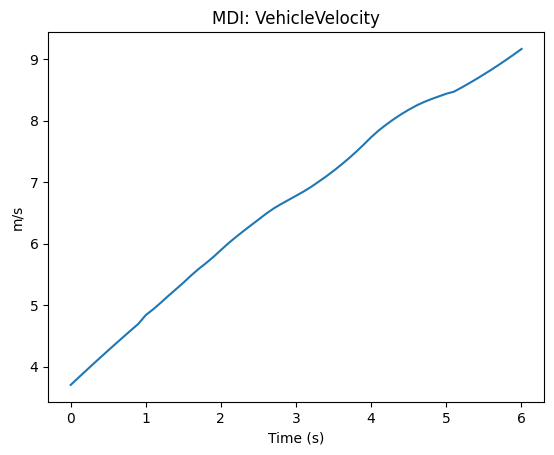

In [2]:
from scipy import signal

motor_voltage: TimeSeries = client.query_time_series(start, stop, "BatteryVoltage", units="V")
motor_current: TimeSeries = client.query_time_series(start, stop, "BatteryCurrent", units="A")
vehicle_velocity: TimeSeries = client.query_time_series(start, stop, "VehicleVelocity", units="m/s")

# Clean up data a bit
vehicle_velocity = vehicle_velocity.promote(np.where(vehicle_velocity > 10.0, 0, vehicle_velocity))
vehicle_velocity = vehicle_velocity.promote(signal.savgol_filter(vehicle_velocity, WINDOW_SIZE, POLYNOMIAL_ORDER))
vehicle_velocity.plot()

# Align x-axes
motor_current, motor_voltage, vehicle_velocity = TimeSeries.align(motor_current, motor_voltage, vehicle_velocity)

Plot the data to make sure nothing bad or spooky happened (and matches what's seen on InfluxDB Data Explorer).

Now, let's calculate motor power.

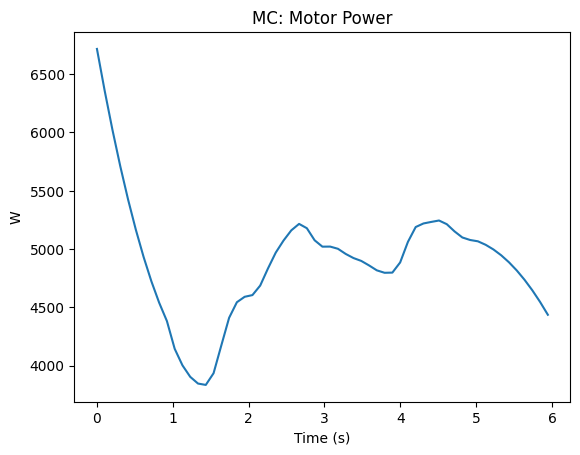

In [3]:
motor_power = motor_current.promote(motor_current * motor_voltage)

# Clean it up a bit and fix the metadata
motor_power = motor_power.promote(signal.savgol_filter(motor_power, WINDOW_SIZE, POLYNOMIAL_ORDER))
motor_power.units = "W"
motor_power.meta["field"] = "Motor Power"
motor_power.plot()

Now, let's use Simulation to predict motor power for the given velocity.

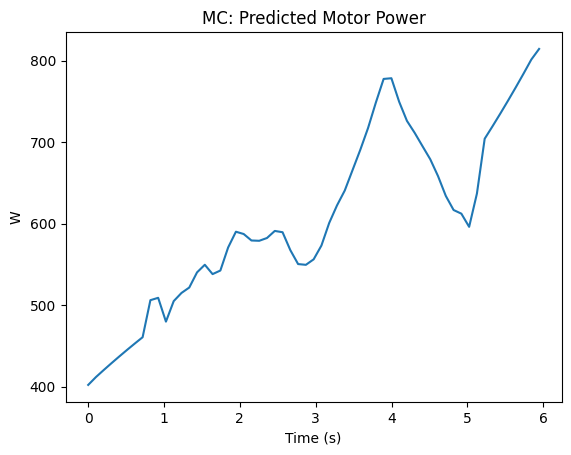

In [4]:
from simulation.model.car.motor import BasicMotor

speed_kmh = vehicle_velocity.promote(vehicle_velocity * 3.6)
speed_kmh.units = "km/h"
speed_kmh.meta["field"] = "Vehicle Speed"

gradients = np.zeros_like(speed_kmh)
wind_speeds = np.zeros_like(speed_kmh)
tick = speed_kmh.granularity

# Predict motor energy
motor_model = BasicMotor()
predicted_motor_energy = motor_model.calculate_energy_in(required_speed_kmh=speed_kmh, gradients=gradients, wind_speeds=wind_speeds, tick=tick)

# To convert from energy to power, we need to divide by time
predicted_motor_power = motor_power.promote(predicted_motor_energy / tick)
predicted_motor_power.meta["field"] = "Predicted Motor Power"
predicted_motor_power.plot()

Not very good. Let's make it better.

In [5]:
from scipy import optimize

# READ: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

def get_motor_power(speeds, *args):  # Helper function for curve fitting
    predicted_motor_energy = motor_model.calculate_energy_in(required_speed_kmh=speeds, gradients=gradients, wind_speeds=wind_speeds, tick=tick, parameters=args)

    return predicted_motor_energy / tick  # Convert from J to W by dividing by time

guess_coefficients = motor_model.parameters
opt, var = optimize.curve_fit(get_motor_power, speed_kmh, motor_power, guess_coefficients)

print(f"Parameters: {opt}")
print(f"Covariance Diagonal: {var.diagonal()}")

Parameters: [ 6.59203445 -0.29195461 -0.23740474 20.0280217 ]
Covariance Diagonal: [2.79265202e+02 1.71796171e+01 5.07882986e-01 9.08188189e+02]


We used `scipy.curve_fit` to fit two coefficients which scale variables inside of our energy calculation, in order to get the result of that calculation to fit the data we see. Now, let's plot the result with the optimized coefficients that got spit out. We check the covariance diagonal as large orders of magnitude would indicate that our system could be over-parameterized.

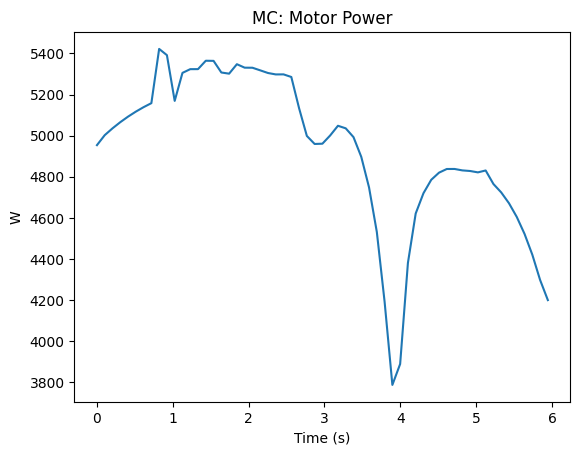

In [9]:
optimized_motor_power = motor_power.promote(get_motor_power(speed_kmh, *opt))
optimized_motor_power.plot()

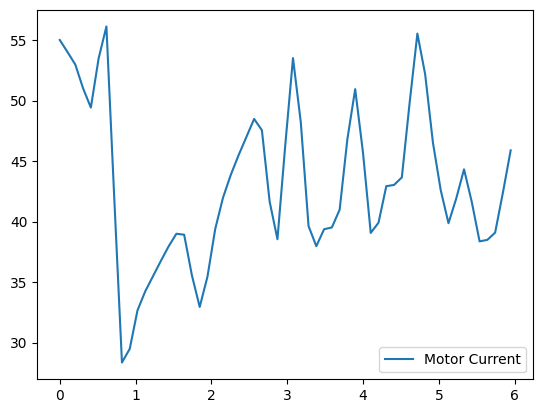

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.plot(optimized_motor_power.x_axis, optimized_motor_power, label="Predicted Motor Power")
# ax.plot(motor_power.x_axis, motor_power, label="Experimental Motor Power")
ax.plot(motor_current.x_axis, motor_current, label="Motor Current")
# ax.set_ylim([0, 1.25 * max(max(optimized_motor_power), max(motor_power))])

plt.legend()
plt.show()

In [8]:
print(f"Drawn Energy, actual: {np.trapz(motor_power, motor_power.x_axis)}")
print(f"Drawn Energy, predicted: {np.trapz(optimized_motor_power, optimized_motor_power.x_axis)}")

Drawn Energy, actual: 29034.107250976536
Drawn Energy, predicted: 28488.74928586987
